In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.neighbors import KernelDensity  # kernel density estimation
from mpmath import jtheta  # jacobi elliptic theta function

In [13]:
nea_data = pd.read_csv('NEA.txt', sep='\s+', on_bad_lines='skip', header=None)
nea_data

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,00433,10.41,0.15,K243V,334.72747,178.89533,304.27657,10.82763,0.222707,0.55974267,...,57,1893-2024,0.54,M-v,3Ek,MPCLINUX,1804,(433),Eros,20240416.0
1,00719,15.59,0.15,K243V,102.37224,156.22215,183.85474,11.57578,0.546897,0.23028019,...,22,1911-2024,0.57,M-v,3Ek,MPCLINUX,1804,(719),Albert,20240215.0
2,00887,13.87,0.15,K243V,289.47572,350.47806,110.42481,9.39881,0.571013,0.25356814,...,39,1918-2024,0.66,M-v,3Ek,MPCLINUX,1804,(887),Alinda,20240627.0
3,01036,9.25,0.15,K243V,321.69056,132.48332,215.49723,26.68672,0.532847,0.22648412,...,62,1924-2024,0.60,M-v,3Ek,MPCLINUX,1804,(1036),Ganymed,20240628.0
4,01221,17.38,0.15,K243V,197.64174,26.67577,171.30753,11.87591,0.435206,0.37054894,...,21,1932-2023,0.83,M-v,3Ek,MPCLINUX,1804,(1221),Amor,20231011.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6643,q4522,20.54,0.15,K243V,87.75293,355.41113,231.46734,9.03679,0.410183,1.60127598,...,5,2002-2018,0.48,M-v,3Ek,Pan,8802,(524522),Zoozve,20181203.0
6644,x4913,16.20,0.15,K243V,315.88503,187.34841,6.69645,15.86843,0.177123,2.38127071,...,5,2020-2023,0.72,M-v,3Ek,MPCLINUX,1801,(594913),'Aylo'chaxnim,20230921.0
6645,y5911,19.22,0.15,K243V,351.41152,205.26226,289.61070,14.49785,0.294607,0.41418312,...,7,2011-2023,0.61,M-v,3Ek,MPCLINUX,0804,(605911),Cecily,20231215.0
6646,z4470,18.39,0.15,K243V,5.17609,336.92851,0.15227,6.72851,0.594805,0.27173356,...,5,2002-2021,0.59,M-v,3Ek,MPCLINUX,8803,(614470),Flordeneu,20210106.0


In [15]:
nea_data[nea_data.apply(lambda row: row.astype(str).str.contains('703').any(), axis=1)]

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
70,04503,15.82,0.15,K243V,243.42397,76.24657,45.94757,2.51298,0.524600,0.22175702,...,17,1980-2023,0.74,M-v,3Ek,MPCLINUX,1804,(4503),Cleobulus,20230903.0
105,08013,17.09,0.15,K243V,130.76622,146.97033,105.46542,7.57251,0.431306,0.30161789,...,19,1951-2023,0.76,M-v,3Ek,MPCLINUX,1804,(8013),Gordonmoore,20231230.0
116,11885,18.52,0.15,K243V,330.67663,116.19174,359.78220,19.43071,0.474481,0.44333862,...,7,1990-2023,0.73,M-v,3Ek,MPCLINUX,0803,(11885),Summanus,20230904.0
146,G1989,17.31,0.15,K243V,173.09343,102.09032,161.21402,26.06390,0.213811,0.82852720,...,11,1978-2023,0.65,M-v,3Ek,MPCLINUX,9803,(161989),Cacus,20230128.0
167,J94N00K,20.08,0.15,K243V,104.47101,128.89248,119.79851,5.68051,0.538237,0.27324389,...,3,1994-2019,0.60,M-v,3Ek,MPCLINUX,0804,1994,NK,20190204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6403,K22H07P,19.78,0.15,K243V,137.74215,331.73466,346.30265,6.06485,0.469903,0.25775532,...,3,2007-2022,0.42,M-v,3Ek,Veres,0804,2022,HP7,20220703.0
6541,K23E02N,23.12,0.15,K243V,241.81781,272.45532,5.80178,7.79136,0.298469,0.82437703,...,3,2017-2023,0.62,M-v,3Ek,Veres,0803,2023,EN2,20231216.0
6587,K23O24E,20.93,0.15,K243V,129.54862,241.55176,44.09542,7.99865,0.270317,0.43826370,...,3,2005-2023,0.14,M-v,3Ek,MPCLINUX,0804,2023,OE24,20231019.0
6595,K23R02M,20.42,0.15,K243V,82.15422,209.19169,213.41300,20.69804,0.436854,0.62925875,...,3,2021-2024,0.59,M-v,3Ek,Veres,0803,2023,RM2,20240507.0


$q = a\left(1 - e\right)$

In [18]:
orb_param_array_all_events = np.load('orb_params_all_events_mc.npy')  # get the orbital parameters
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  
a, e, i, peri, node, M = orb_param_array_all_events.T

In [25]:
q = a * (1. - e)

array([0.57897262, 0.95560869, 0.77158344, ..., 0.93373936, 0.29388686,
       0.9583062 ])

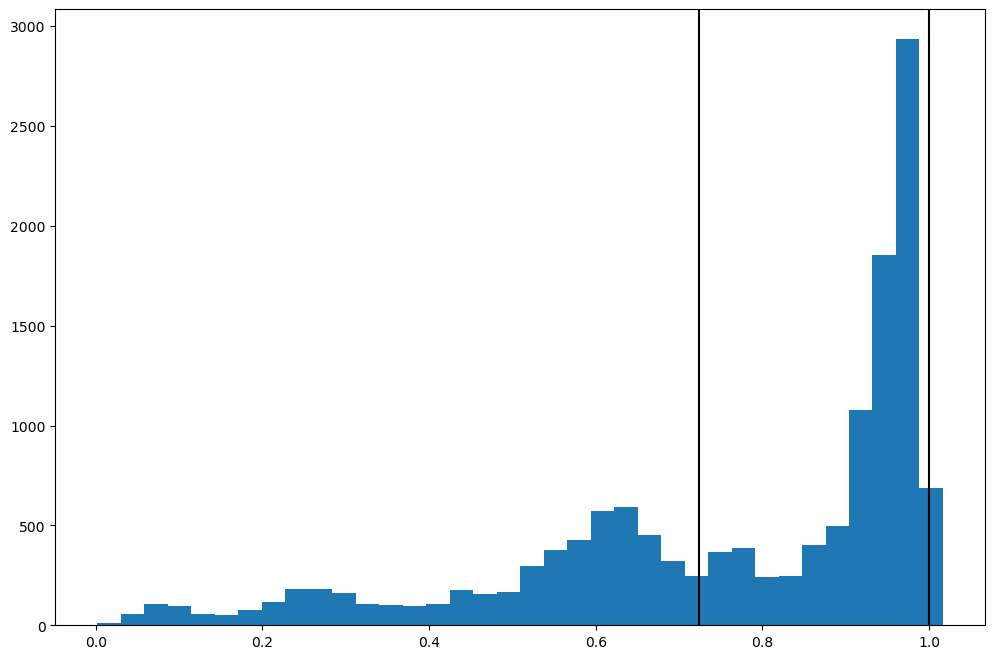

In [33]:
a_earth = 1.
a_venus = 0.72333199

plt.figure(figsize = (12, 8))
plt.hist(q.reshape(-1), bins='auto')
plt.axvline(a_earth, color = 'k')
plt.axvline(a_venus, color = 'k')